In [53]:
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import History 

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
os.chdir("/content/drive/MyDrive/Knowledge-Distillation")
os.listdir()

['MNIST_KD.ipynb',
 'models',
 'plot_utils',
 'actions',
 'CIFAR10_ResNet18.h5',
 'CIFAR10_Student_Model.h5',
 'alpha_temp.npy',
 'CIFAR-10.ipynb',
 'amount_data.npy']

In [56]:
import models.ResNet18 as ResNet18
import models.CIFAR10_Student_Model as CIFAR10_Student
import plot_utils.Plot_Heatmap
import plot_utils.Plot_Model
import actions.Classification_Distiller as Distiller

In [57]:
def loadDataset():
  (trainX, trainy), (testX, testy) = cifar10.load_data()

  trainy = trainy
  testy  = testy
  
  train_norm = trainX.astype('float32')/255.0
  test_norm  = testX.astype('float32')/255.0

  return train_norm, trainy, test_norm, testy

In [58]:
trainX, trainy, testX, testy = loadDataset()

# Teacher Model

In [ ]:
teacher = ResNet18.ResNet18(classes=10, input_shape=(32,32,3))

In [ ]:
teacher.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 32, 32, 64)   1728        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 32, 32, 64)   256         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 32, 32, 64)   0           batch_normalization_40[0][0]     
___________________________________________________________________________________________

In [ ]:
teacher.compile(
      optimizer=SGD(lr=0.1, momentum=0.9, nesterov=False),
      loss=SparseCategoricalCrossentropy(from_logits=True),
      metrics=[SparseCategoricalAccuracy()],
  )

In [64]:
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if (epoch+1) % 30 == 0: new_lr = lr * 0.1
    else:                   new_lr = lr
    
    print('lr: %.2e' % new_lr)
    return new_lr 

lr_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
              width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
              height_shift_range=4,  # randomly shift images vertically (fraction of total height)
              horizontal_flip=True,  # randomly flip images
          )
          
train_gen = datagen.flow(trainX, trainy, batch_size=64)
teacher.fit_generator(train_gen, epochs=90, validation_data=(testX, testy), callbacks=[History(), lr_callback], verbose=1)

lr: 1.00e-01
Epoch 1/90
782/782 [==============================] - 116s 148ms/step - loss: 2.3139 - sparse_categorical_accuracy: 0.3449 - val_loss: 2.1725 - val_sparse_categorical_accuracy: 0.3798
lr: 1.00e-01
Epoch 2/90
782/782 [==============================] - 115s 148ms/step - loss: 1.6935 - sparse_categorical_accuracy: 0.5172 - val_loss: 1.9334 - val_sparse_categorical_accuracy: 0.4429
lr: 1.00e-01
Epoch 3/90
782/782 [==============================] - 115s 147ms/step - loss: 1.3685 - sparse_categorical_accuracy: 0.6240 - val_loss: 1.6622 - val_sparse_categorical_accuracy: 0.5544
lr: 1.00e-01
Epoch 4/90
782/782 [==============================] - 115s 147ms/step - loss: 1.1625 - sparse_categorical_accuracy: 0.6884 - val_loss: 1.8154 - val_sparse_categorical_accuracy: 0.5503
lr: 1.00e-01
Epoch 5/90
782/782 [==============================] - 115s 147ms/step - loss: 1.0292 - sparse_categorical_accuracy: 0.7311 - val_loss: 1.1615 - val_sparse_categorical_accuracy: 0.6920
lr: 1.00e-01
Ep

**The teacher model is able to achieve an accuracy of about 93.55%**

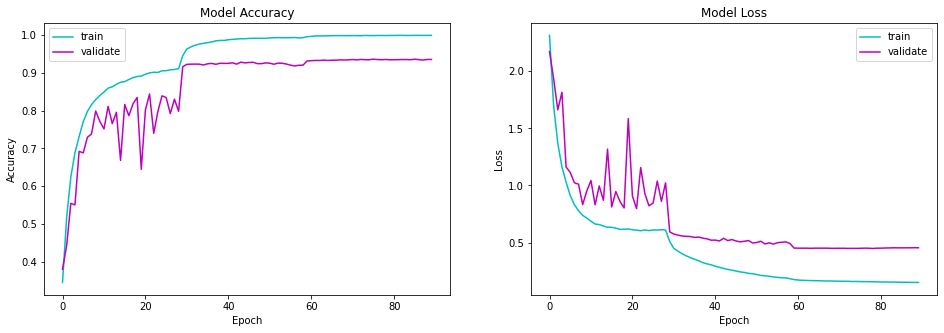

In [ ]:
plot_utils.Plot_Model.plotModel(teacher.history)

## Save the model

In [8]:
def saveModel(inp_model, filename):
  inp_model.save(filename)
  return

def loadModel(filename):
  model = load_model(filename)
  return model

In [9]:
# saveModel(teacher, "CIFAR10_ResNet18.h5")

In [59]:
teacher = loadModel("CIFAR10_ResNet18.h5")

# Student Model

In [ ]:
# import importlib
# importlib.reload(CIFAR10_Student)
student_model_1 = CIFAR10_Student.createStudentModel()

In [ ]:
student_model_1.summary()

Model: "Student-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_67 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_68 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 64)      

In [ ]:
student_model_1.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=[SparseCategoricalAccuracy()],
    )

In [ ]:
student_model_1.fit(trainX, trainy, epochs=50, batch_size=64, validation_data=(testX, testy), verbose=1, callbacks=[History()])

Epoch 1/50
782/782 [==============================] - 17s 22ms/step - loss: 1.6047 - sparse_categorical_accuracy: 0.4510 - val_loss: 1.1530 - val_sparse_categorical_accuracy: 0.5816
Epoch 2/50
782/782 [==============================] - 17s 21ms/step - loss: 1.0658 - sparse_categorical_accuracy: 0.6195 - val_loss: 0.9704 - val_sparse_categorical_accuracy: 0.6551
Epoch 3/50
782/782 [==============================] - 16s 21ms/step - loss: 0.8771 - sparse_categorical_accuracy: 0.6896 - val_loss: 0.9681 - val_sparse_categorical_accuracy: 0.6607
Epoch 4/50
782/782 [==============================] - 17s 21ms/step - loss: 0.7726 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.7159 - val_sparse_categorical_accuracy: 0.7521
Epoch 5/50
782/782 [==============================] - 17s 21ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.6398 - val_sparse_categorical_accuracy: 0.7779
Epoch 6/50
782/782 [==============================] - 17s 21ms/step - loss: 0.6359 - spars

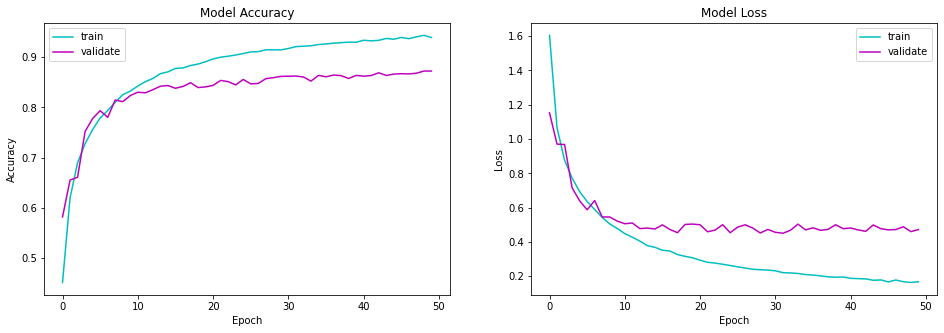

In [ ]:
# import importlib 
# importlib.reload(plot_utils.Plot_Model)
plot_utils.Plot_Model.plotModel(student_model_1.history)

**The student model is able to achieve an accuracy of about 87.25% without knowledge distillation**

In [ ]:
# saveModel(student_model_1, "CIFAR10_Student_Model.h5")

In [ ]:
student_model_1 = loadModel("CIFAR10_Student_Model.h5")

# Experiments on Knowledge Distillation

## Experiment:
**Q) Effect of the hyperparameters alpha and temperature on the knowledge distillation of a deep teacher model (ResNet18 in this case) on a shallow student model (9 layer CNN in this case) ?**

In [ ]:
# import importlib
# importlib.reload(Distiller)
import actions.Classification_Distiller as Distiller

In [ ]:
from tensorflow.keras.losses import KLDivergence

# Initialize and compile distiller
alpha_vals = [0.2, 0.4, 0.6, 0.8, 1.0]
temp_vals  = [2, 4, 6, 8, 10]

res = []

for i in range(len(alpha_vals)):
  alpha = alpha_vals[i]
  res.append([])
  for j in range(len(temp_vals)):
    temp = temp_vals[j]
    curr_student_model = CIFAR10_Student.createStudentModel()
    distiller = Distiller.Distiller(student=curr_student_model, teacher=teacher)
    distiller.compile(
        optimizer=Adam(),
        metrics=[SparseCategoricalAccuracy()],
        student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=KLDivergence(),
        alpha=alpha,
        temperature=temp,
    )

    distiller.fit(trainX, trainy, epochs=50, batch_size=32, verbose=0)
    curr_acc = distiller.evaluate(testX, testy)
    res[i].append(curr_acc)
    print("alpha = ", alpha, ", T = ", temp, ", accuracy = ", curr_acc)

In [ ]:
import numpy as np
accuracy = np.array(res)
print(accuracy)

[[0.8642     0.87840003 0.88489997 0.88789999 0.88489997]
 [0.87650001 0.87940001 0.8865     0.8926     0.89130002]
 [0.86559999 0.88300002 0.88239998 0.89410001 0.89090002]
 [0.87410003 0.88260001 0.889      0.88609999 0.8854    ]
 [0.87050003 0.8811     0.8915     0.89349997 0.89289999]]


### Plotting the heatmap

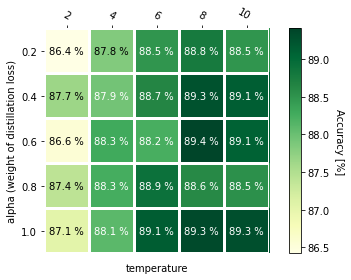

In [ ]:
fig, ax = plt.subplots()
im, cbar = plot_utils.Plot_Heatmap.heatmap(accuracy*100, alpha_vals, temp_vals, "temperature", "alpha (weight of distillation loss)", ax=ax, cmap="YlGn", cbarlabel="Accuracy [%]")
texts = plot_utils.Plot_Heatmap.annotate_heatmap(im, valfmt="{x:.1f} %")

fig.tight_layout()
plt.show()

In [ ]:
# with open('alpha_temp.npy', 'wb') as f:
#   np.save(f, alpha_vals)
#   np.save(f, temp_vals)
#   np.save(f, accuracy)

## Some observations: 

- The distilled model achieves a max accuracy of 89.4%, which is more than 2% improvement than the normal student model.

- alpha value = 1.0 implies that we are taking no account of the hard labels of the data, thus we can achieve an accuracy of 89.3% using only unlabelled data.

# Experiment with amount of training data

In [13]:
from tensorflow.keras.losses import KLDivergence

training_data = [0.05, 0.10, 0.15, 0.25, 0.50, 0.75]
alpha = 0.6
temp  = 8

res = []
res_KD = []

for i in range(len(training_data)):
  curr_student_model_KD = CIFAR10_Student.createStudentModel()
  curr_student_model    = CIFAR10_Student.createStudentModel()

  curr_student_model.compile(
      optimizer=Adam(),
      loss=SparseCategoricalCrossentropy(from_logits=True),
      metrics=[SparseCategoricalAccuracy()],
  )

  distiller = Distiller.Distiller(student=curr_student_model_KD, teacher=teacher)
  distiller.compile(
      optimizer=Adam(),
      metrics=[SparseCategoricalAccuracy()],
      student_loss_fn=SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=KLDivergence(),
      alpha=alpha,
      temperature=temp,
  )

  curr_amount = int(training_data[i]*trainX.shape[0])

  curr_student_model.fit(trainX[0:curr_amount], trainy[0:curr_amount], epochs=50, batch_size=32, verbose=0)
  distiller.fit(trainX[0:curr_amount], trainy[0:curr_amount], epochs=50, batch_size=32, verbose=0)

  curr_acc = curr_student_model.evaluate(testX, testy)
  curr_acc_KD = distiller.evaluate(testX, testy)

  res.append(curr_acc[1])
  res_KD.append(curr_acc_KD)
  
  print("training data = ", int(training_data[i]*100), "%, alpha = ", alpha, ", T = ", temp, ", accuracy witouth KD = ", curr_acc[1], ", accuracy with KD = ", curr_acc_KD)

313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.6811 - loss: 2.4510
training data =  5 %, alpha =  0.6 , T =  8 , accuracy witouth KD =  0.6114000082015991 , accuracy with KD =  0.6811000108718872
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.7301 - loss: 1.9357
training data =  10 %, alpha =  0.6 , T =  8 , accuracy witouth KD =  0.6877999901771545 , accuracy with KD =  0.7300999760627747
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.7782 - loss: 1.6187
training data =  15 %, alpha =  0.6 , T =  8 , accuracy witouth KD =  0.7293000221252441 , accuracy with KD =  0.7781999707221985
313/313 [==============================] - 1s 3ms/step - sparse_categorical_accuracy: 0.8222 - loss: 1.2132
training data =  25 %, alpha =  0.6 , T =  8 , accuracy witouth KD =  0.7809000015258789 , accuracy with KD =  0.8222000002861023
313/313 [==============================] - 1s 3ms

In [15]:
# import numpy as np 

# with open('amount_data.npy', 'wb') as f:
#   np.save(f, training_data)
#   np.save(f, res)
#   np.save(f, res_KD)

In [45]:
print(training_data)

[0.05, 0.1, 0.15, 0.25, 0.5, 0.75]


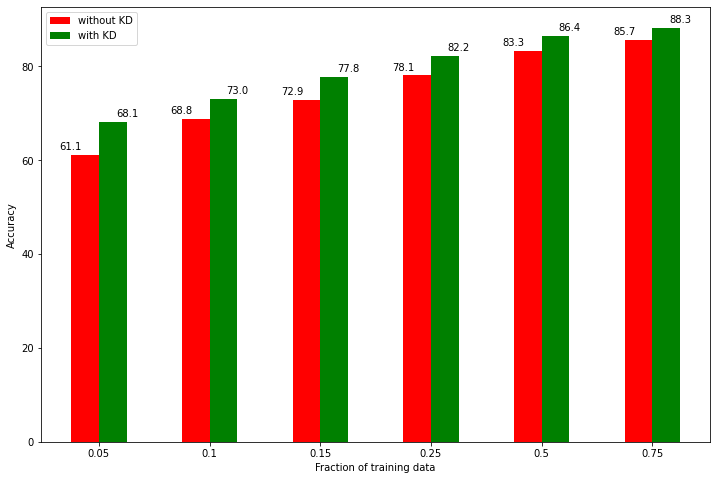

In [52]:
w = 0.3

X = np.arange(len(training_data))
fig, ax = plt.subplots(figsize=(12, 8))

bar = ax.bar(X - 0.125, np.array(res)*100, color = 'r', width = 0.25)
bar_KD = ax.bar(X + 0.125, np.array(res_KD)*100, color = 'g', width = 0.25)

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')
        
autolabel(bar, "left")
autolabel(bar_KD, "right")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Fraction of training data')
ax.set_xticks(range(len(training_data)))
ax.set_xticklabels(training_data)

ax.legend((bar[0], bar_KD[0]), ('without KD', 'with KD'))
plt.show()

## Experiment: 
**Introducing Teaching assistants**: [Reference](https://arxiv.org/pdf/1902.03393.pdf)   